In [118]:
import librosa
from IPython.display import Audio
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchaudio
from torch.utils.data import DataLoader
import audiomentations
from sklearn.preprocessing import LabelEncoder
import torchaudio

In [363]:
class CONFIG:
    ramdom_seed= 42
    
    sample_rate = 32000
    duration=10
    audio_len = duration*sample_rate
    target_len = duration*sample_rate
    
    img_size = [128,256]
    num_classes = 264
    batch_size = 32
    
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True

    prob_fm = 0.45

    

In [17]:
meta_train2023.loc[meta_train2023['primary_label'].str.contains('crefra')]

primary_label secondary_labels                                type  \
5529       crefra2               []  ['adult', 'call', 'sex uncertain']   

      latitude  longitude      scientific_name        common_name  \
5529   -0.5283    31.0002  Ortygornis sephaena  Crested Francolin   

             author                                            license  \
5529  Niall Perrins  Creative Commons Attribution-NonCommercial-Sha...   

      rating                           url              filename  \
5529     3.0  http://xeno-canto.org/667443  crefra2/XC667443.ogg   

                                filepath  class  
5529  ./train_audio/crefra2/XC667443.ogg     75

In [56]:
meta_train2023['primary_label'].value_counts()

comsan     500
barswa     500
eaywag1    500
wlwwar     500
thrnig1    500
          ... 
afpkin1      1
brtcha1      1
whhsaw1      1
crefra2      1
lotcor1      1
Name: primary_label, Length: 264, dtype: int64

In [5]:
# Load metadata
meta_train2023 = pd.read_csv("train_metadata.csv")
meta_train2023.head(5)
meta_train2023['filepath'] = './train_audio/'+meta_train2023['filename']
# Encode Labels
le = LabelEncoder()
meta_train2023['class'] = le.fit_transform(meta_train2023['primary_label'])

In [200]:
au ,sr = librosa.load(meta_train2023['filepath'].iloc[66] ,sr=None)
print(au.shape)
Audio(au,rate=sr)

(578304,)


In [230]:
def crop_or_pad(audio, target_len = CONFIG.target_len
                , pad_mode='constant', take_first=True):
    audio_len = audio.shape[0]
    diff_len = abs(target_len - audio_len)
    if audio_len < target_len:
        # padding audio tensor at a random start point
        pad1 = torch.randint(high=diff_len, size=[], dtype=torch.int32)
        pad2 = diff_len - pad1
        audio = torch.nn.functional.pad(audio, (pad1.item(), pad2.item()), mode=pad_mode)
    elif audio_len > target_len:
        if take_first:
            audio = audio[:target_len]
        else:
            idx = torch.randint(high=diff_len, size=[], dtype=torch.int32)
            audio = audio[idx.item(): (idx.item() + target_len)]
    return torch.reshape(audio, [target_len])

In [229]:
CONFIG.target_len

320000

In [224]:
au = torch.tensor(au)
Audio(au,rate=sr)

/var/folders/xy/d1ssf3xj77s6df5yg79rhp1c0000gn/T/ipykernel_2924/2211996684.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  au = torch.tensor(au)


In [231]:
fixed_au = crop_or_pad(au)
print(len(fixed_au))
Audio(fixed_au,rate=32000)

320000


In [364]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift,SpecFrequencyMask
import numpy as np
def audio_augment(audio):
    
    augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.35),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.45),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.45),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.45),
    ])
    
    audio = audio.numpy()
    aug_audio = augment(samples=audio, sample_rate=CONFIG.sample_rate)
    return torch.tensor(aug_audio)



def get_spectrogram(audio):
    audio = audio.numpy()
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CONFIG.sample_rate, 
                                   n_mels=CONFIG.img_size[0],
                                   n_fft=CONFIG.nfft,
                                   hop_length=CONFIG.hop_length,
                                   fmax=CONFIG.fmax,
                                   fmin=CONFIG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    return torch.tensor(spec).reshape((1, spec.shape[0],spec.shape[1]))


def spec_augmentation(spec):
    # TimeFrequencyMask
    #  Add random factor to Frequency Masking
    rand_prob = float(torch.rand(1))
    transfom1 = torchaudio.transforms.FrequencyMasking(freq_mask_param=10)
    transfom2 = torchaudio.transforms.TimeMasking(time_mask_param=25,p=0.5)
    if rand_prob >= CONFIG.prob_fm:
        spec = transfom1(spec)
        spec = transfom2(spec)
    else:
        spec = transfom2(spec)
    return spec

In [232]:
aug_au = audio_augment(fixed_au)
print(aug_au.shape)
Audio(aug_au,rate=CONFIG.sample_rate)

torch.Size([320000])


torch.Size([1, 128, 462])


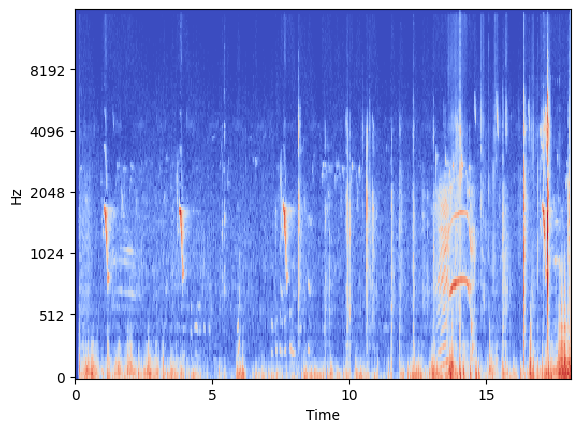

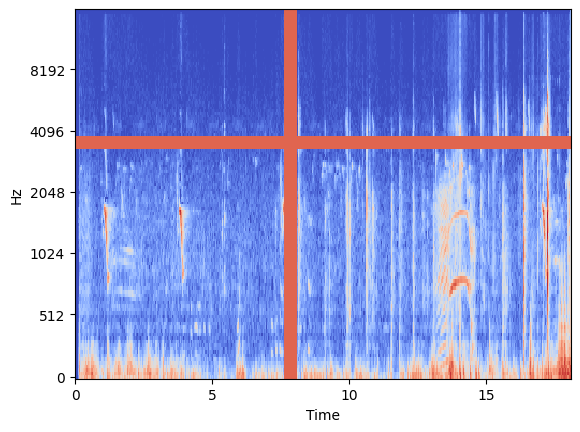

In [386]:
au2spec = get_spectrogram(au)
print(au_spec.shape)

import librosa.display as lid
lid.specshow(au2spec[0].numpy(), 
             n_fft=CONFIG.nfft, 
             hop_length=CONFIG.hop_length, 
             sr=CONFIG.sample_rate,
            x_axis='time',
            y_axis='mel',
            cmap='coolwarm')
plt.show()

lid.specshow(spec_augmentation(au2spec)[0].numpy(), 
             n_fft=CONFIG.nfft, 
             hop_length=CONFIG.hop_length, 
             sr=CONFIG.sample_rate,
            x_axis='time',
            y_axis='mel',
            cmap='coolwarm')
plt.show()

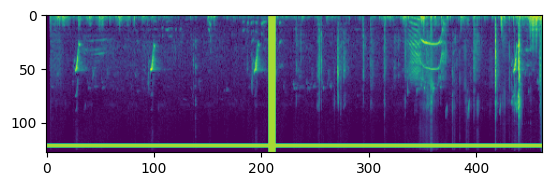

In [415]:
plt.imshow(spec_augmentation(au2spec)[0].numpy())

In [421]:
import torchvision

In [424]:
torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

In [436]:
spec2img = cv2.cvtColor(au2spec[0].numpy(), cv2.COLOR_GRAY2RGB)

In [437]:
spec2img.shape

(128, 462, 3)

In [512]:
def spec_norm(mel_spectrogram):
    mel_spectrogram = mel_spectrogram[0]
    mean = torch.mean(mel_spectrogram, dim=1)
    std = torch.std(mel_spectrogram, dim=1)

    # Expand the mean and standard deviation tensors to have the same shape as the original spectrogram
    mean = mean.unsqueeze(1).expand_as(mel_spectrogram)
    std = std.unsqueeze(1).expand_as(mel_spectrogram)

    # Normalize the spectrogram by subtracting the mean and dividing by the standard deviation
    normalized_mel_spectrogram = (mel_spectrogram - mean) / std

    # You can also apply additional operations such as clipping or scaling if desired
    # For example, to clip the normalized spectrogram to a specific range, you can use torch.clamp:
    min_value = 0.0
    max_value = 1.0
    h = mel_spectrogram.shape[0]
    w = mel_spectrogram.shape[1]
    normalized_mel_spectrogram = torch.clamp(normalized_mel_spectrogram, min=min_value, max=max_value)
    return normalized_mel_spectrogram.reshape((1,h,w))

In [522]:
mel_spectrogram.shape

torch.Size([128, 462])

In [507]:
mel_spectrogram = au2spec[0]

In [510]:
normalized_mel_spectrogram 

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [515]:
mean = torch.mean(mel_spectrogram, dim=1)
std = torch.std(mel_spectrogram, dim=1)

# Expand the mean and standard deviation tensors to have the same shape as the original spectrogram
mean = mean.unsqueeze(1).expand_as(mel_spectrogram)
std = std.unsqueeze(1).expand_as(mel_spectrogram)

# Normalize the spectrogram by subtracting the mean and dividing by the standard deviation
normalized_mel_spectrogram = (mel_spectrogram - mean) / std

# You can also apply additional operations such as clipping or scaling if desired
# For example, to clip the normalized spectrogram to a specific range, you can use torch.clamp:
min_value = 0.0
max_value = 1.0
normalized_mel_spectrogram = torch.clamp(normalized_mel_spectrogram, min=min_value, max=max_value)


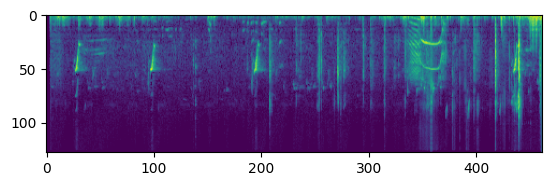

In [516]:
plt.imshow(mel_spectrogram 

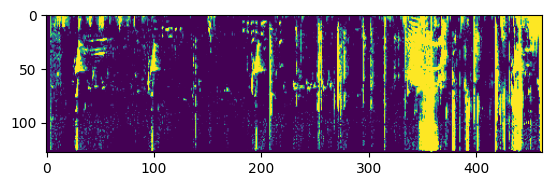

In [477]:
plt.imshow(normalized_mel_spectrogram)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


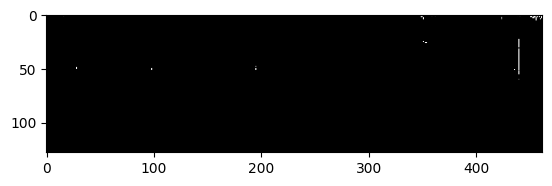

In [481]:
plt.imshow(cv2.cvtColor(mel_spectrogram.numpy()
, cv2.COLOR_GRAY2RGB)[:,:,::-1])

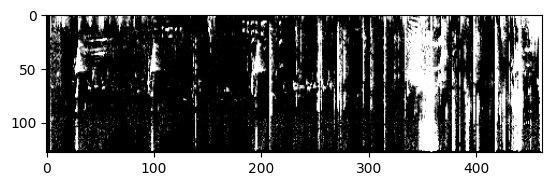

In [480]:
plt.imshow(cv2.cvtColor(normalized_mel_spectrogram.numpy()
, cv2.COLOR_GRAY2RGB)[:,:,::-1])

In [543]:
torch.tensor(cv2.cvtColor(normalized_mel_spectrogram[0].numpy()
, cv2.COLOR_GRAY2RGB),dtype=float)

tensor([[[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]],

        ...,

        [[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]], dtype=torch.float64)

In [483]:
resize = torchvision.transforms.Resize(CONFIG.img_size)

In [519]:
resize(mel_spectrogram.reshape((1,128,462))).shape

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 128, 256])

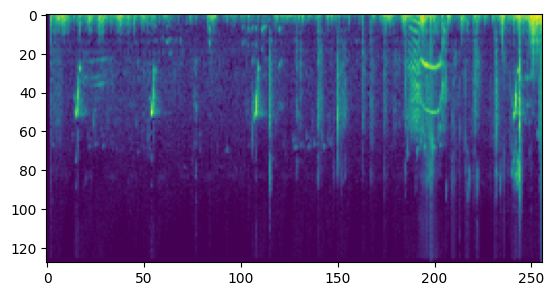

In [494]:
plt.imshow(resize(mel_spectrogram.reshape((1,128,462)))[0].numpy())

In [573]:
class AudioDataset(Dataset):
    from torch.nn.functional import one_hot
    def __init__(self,audio_df, transform=None):
        self.audio_df = audio_df
        self.transform = transform
    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        audio_path = self.audio_df['filepath'].iloc[idx]
        label = self.audio_df['class'].iloc[idx]
        audio,sr = librosa.load(audio_path,sr=None)
        audio = torch.tensor(audio)
        audio = crop_or_pad(audio)
        label_1hot = one_hot(torch.tensor(label), num_classes=CONFIG.num_classes)
        audio= audio_augment(audio)

        # Spectrumgram Augmentations
        spec = get_spectrogram(audio)
        spec = spec_augmentation(spec).reshape((1, spec[0].shape[0], spec[0].shape[1]))

        # resize Spectrumgram
        resize = torchvision.transforms.Resize(CONFIG.img_size)
        spec =  resize(spec)[0]
        # Normalize
        spec =spec_norm(spec)[0]

        # Conver GRAY into RGB
        spec_img = torch.tensor(cv2.cvtColor(spec.numpy()
    , cv2.COLOR_GRAY2RGB), dtype=float)
            
        sample  = {'img':spec_img,'label':label_1hot}
        if self.transform:
            sample = self.transform(sample)
        return sample